## Description:

This file contains:
* target variable encoding
* fill na, drop unnecessary cols
* make train-val-test sets
* dummy model (all features)
* LGBM (all features)

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import time


'''Pre-processing'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

'''Modeling'''
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, plot_confusion_matrix


'''GCS Utils'''
from gcs_utils import upload_serialized_file, upload_csv_file, download_file

import warnings
warnings.filterwarnings('ignore')

SEED=42

In [2]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'
file_name = 'training_data_11192021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

### Training Data - Features

**Numerical Features**
1. User metrics
    * unique pageviews per session (avg, median)
    * timeOnPage per session (avg, median) <br><br>
2. Session metrics
    * bounceRate  <br><br>
3. Content metrics
    * contentViewsRate (contentViews / pageViews) <br>

**Categorical Features**
1. Content categories 
    * Sum pvs - Tier1, Tier2, Primary Channel, Primary Section
    * Avg. top - Tier1 <br><br>
2. Timestamp features: 

    * Weekday vs Weekend 
        * Sum pvs & avg. top
    * Business Hours vs Non-Business Hours *(Differentiated by US and other countries)*
        * Sum pvs & avg. top
    * Day of week
        * avg. top
    * Day of month
        * avg. top
    * Hourly *(Differentiated by US and other countries)*
        * avg. top
    * Minute *(Differentiated by US and other countries)*
        * avg. top<br><br>
3. Device OS - Sum pvs
4. Referral source - Sum pvs
5. Countries - Sum pvs<br><br>

In [2]:
# read training data

df = pd.read_csv('training_data_11192021.csv', dtype={'ga_fullvisitorid': object})

print(df.shape)
print(df.isna().sum().unique())

(507937, 627)
[0]


* For round 1 - categorical features generated using pivots of sum(pvs) - for time save + convenience
* Advanced - discussed in next steps

In [3]:
df.head()

,ga_fullvisitorid,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,...,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top,subscription_status
0,10000145548747950113,1.0,1.0,454.0,454.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
1,10000150578546110250,1.0,1.0,14.5,12.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,non_subscriber
2,10000154461756058018,1.0,1.0,52.0,52.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
3,10000244735129548321,1.0,1.0,32.0,32.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
4,10000256049462665870,1.0,1.0,15.0,15.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber


In [4]:
df.dtypes.value_counts()

float64    623
object       2
int64        2
dtype: int64

* Fill NA
* Drop unnecesary cols
* Encode target variable

In [5]:
# fill any Nulls with 0

df.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in df.columns if 'other' in x] + ['ga_fullvisitorid']

df = df.drop(cols_to_drop, 
             axis=1)

# encode target - subs class 1, everyone else class 0

df['subscription_status'] = np.where(df['subscription_status']=='subscriber',
                                     1, 0)

In [6]:
df.subscription_status.value_counts()

0    409990
1     97947
Name: subscription_status, dtype: int64

**Train - test split**
* Why train-test split before feature selection - to avoid information leakage

In [7]:
X = df.iloc[:, :-1]
y = df["subscription_status"]

# split the data in training and remaining dataset

X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y, 
                                                  train_size=0.7, 
                                                  stratify = y,
                                                  random_state = SEED 
                                                 )


# make test and val sets
X_val, X_test, y_val, y_test = train_test_split(X_rem,
                                                y_rem, 
                                                test_size=0.5,
                                                stratify = y_rem,
                                                random_state = SEED 
                                                )

* For all experiments, train and val sets will be used. 
* Test = left untouched

In [8]:
print("--- Train set ---", X_train.shape, y_train.shape, round(X_train.shape[0]/df.shape[0], 2))

print("--- Val set ---", X_val.shape, y_val.shape, round(X_val.shape[0]/df.shape[0], 2))

print("--- Test set ---", X_test.shape, y_test.shape, round(X_test.shape[0]/df.shape[0], 2))

--- Train set --- (355555, 618) (355555,) 0.7
--- Val set --- (76191, 618) (76191,) 0.15
--- Test set --- (76191, 618) (76191,) 0.15


**Save files**<br>

In [9]:
train_set = X_train.join(y_train)
val_set = X_val.join(y_val)
test_set = X_test.join(y_test)

In [13]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'

# save locally and upload .csv 
file_name = 'train_set_11222021.csv'

upload_csv_file(train_set, 
                BUCKET_NAME, 
                BUCKET_FOLDER, 
                file_name) 

# save locally and upload .csv 
file_name = 'val_set_11222021.csv'

upload_csv_file(val_set, 
                BUCKET_NAME, 
                BUCKET_FOLDER, 
                file_name) 

# save locally and upload .csv 
file_name = 'test_set_11222021.csv'

upload_csv_file(test_set, 
                BUCKET_NAME, 
                BUCKET_FOLDER, 
                file_name) 

File uploaded to gs://bi-subscription-modeling/train-val-data/train_set_11222021.csv
File uploaded to gs://bi-subscription-modeling/train-val-data/val_set_11222021.csv
File uploaded to gs://bi-subscription-modeling/train-val-data/test_set_11222021.csv


* **Dummy classifier** 
    * All features
    * Scaled feature values
    * Imbalanced dataset

In [10]:
scoring='f1_weighted'
stkf = StratifiedKFold(5)

In [11]:
scaler = RobustScaler()

dummy = DummyClassifier(strategy='stratified') # stratified because of class imbalance

dummy = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', dummy)
    ]
)

dummy_score = cross_val_score(
    dummy,
    X_train,
    y_train,
    cv=stkf,
    n_jobs=-1,
    scoring=scoring
)

print(dummy_score)
print("Dummy average score is", np.mean(dummy_score))

[0.68730487 0.68895557 0.6853725  0.69013019 0.6912622 ]
Dummy average score is 0.6886050674260386


* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset

In [12]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=stkf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.9913862  0.99136199 0.99053425 0.99079319 0.99089561]
LGBM base score is 0.9909942469067328


                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61499
    subscriber       0.97      0.99      0.98     14692

      accuracy                           0.99     76191
     macro avg       0.98      0.99      0.99     76191
  weighted avg       0.99      0.99      0.99     76191



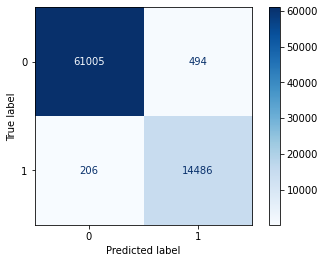

In [12]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

In [ ]:
# crazy overfitting? check bias? - DONE

* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

scoring='f1_weighted'

skf = StratifiedKFold(n_splits = 10, 
                      shuffle=True,
                      random_state = SEED)

sss = StratifiedShuffleSplit(n_splits = 5, 
                             test_size = 0.2, 
                             random_state = SEED) 

In [15]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99167605 0.99095274 0.9910073  0.99131381 0.99153246 0.99105726
 0.99237712 0.99041639 0.99048477 0.99050226]
LGBM base score is 0.9911320158880873


In [17]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=sss, # using StratifiedKFold w/ shuffle=True
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99108299 0.99112879 0.99128756 0.99093799 0.9912009 ]
LGBM base score is 0.9911276472851209


In [23]:
# just checking col names

t1_pv_cols =        [col for col in df.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in df.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in df.columns if 't2_' in col]
pc_cols =           [col for col in df.columns if 'pc_' in col]
ps_cols =           [col for col in df.columns if 'ps_' in col]
deviceos_cols =     [col for col in df.columns if 'dos_' in col]
referral_cols =     [col for col in df.columns if 'rf_' in col]
country_cols =      [col for col in df.columns if 'ct_' in col]

wk_pv_cols =        [col for col in df.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in df.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in df.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in df.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in df.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in df.columns if 'hour_' in col] 
minute_cols =       [col for col in df.columns if 'minute_' in col]
dow_cols =          ['friday_top', 'monday_top', 'saturday_top', 'sunday_top', 'thursday_top', 'tuesday_top', 'wednesday_top']


# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')
ps_cols.remove('t1_family_and_relationships_pvs')
ps_cols.remove('t1_family_and_relationships_top')
ps_cols.remove('t2_apprenticeships_pvs')
ps_cols.remove('t2_celebrity_relationships_pvs')
ps_cols.remove('t2_workshops_and_classes_pvs')


categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + minute_cols  + dow_cols
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_pvs_median', 'session_top_mean', 'session_top_median', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

612
6


In [24]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

def anova_test(df, columns):

    correlated_cols = []
    non_correlated_cols = []

    for col in columns:
        cat, num = "subscription_status", col
        model = smf.ols(num+' ~ '+cat, data=df).fit()
        table = sm.stats.anova_lm(model)
        p = table["PR(>F)"][0]
        coeff, p = None, round(p, 3)
        conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
        if conclusion =="Correlated":
            correlated_cols.append(col)
        else:
            non_correlated_cols.append(col)

    # print("Anova F: the correlated variables are", conclusion, "(p-value: "+str(p)+")")
    print("Anova F: the correlated variables are:")
    print(correlated_cols)
    print()
    print("Anova F: the non-correlated variables are:")
    print(non_correlated_cols)

In [25]:
anova_test(df, numerical_cols)

Anova F: the correlated variables are:
['session_pvs_mean', 'session_pvs_median', 'session_top_mean', 'session_top_median', 'bounce_rate', 'content_views_rate']

Anova F: the non-correlated variables are:
[]


In [26]:
anova_test(df, categorical_cols) # 2mins

Anova F: the correlated variables are:
['t1_automotive_pvs', 't1_books_and_literature_pvs', 't1_business_and_finance_pvs', 't1_careers_pvs', 't1_content_channel_pvs', 't1_education_pvs', 't1_events_and_attractions_pvs', 't1_family_and_relationships_pvs', 't1_fine_art_pvs', 't1_food_and_drink_pvs', 't1_healthy_living_pvs', 't1_hobbies_and_interests_pvs', 't1_home_and_garden_pvs', 't1_medical_health_pvs', 't1_movies_pvs', 't1_music_and_audio_pvs', 't1_news_and_politics_pvs', 't1_personal_finance_pvs', 't1_pets_pvs', 't1_pop_culture_pvs', 't1_real_estate_pvs', 't1_religion_and_spirituality_pvs', 't1_science_pvs', 't1_shopping_pvs', 't1_sports_pvs', 't1_style_and_fashion_pvs', 't1_technology_and_computing_pvs', 't1_television_pvs', 't1_travel_pvs', 't1_video_gaming_pvs', 't1_automotive_top', 't1_books_and_literature_top', 't1_business_and_finance_top', 't1_careers_top', 't1_content_channel_top', 't1_education_top', 't1_events_and_attractions_top', 't1_family_and_relationships_top', 't1_fin